In [ ]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import filters
from utils import *
import nibabel as nib
from scipy.stats import f_oneway
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score  # Importing silhouette_score
from sklearn.preprocessing import StandardScaler
from skimage.filters import threshold_otsu
from sklearn.metrics import f1_score, accuracy_score, recall_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [ ]:
cwd = os.getcwd()
df = pd.read_excel(f'{cwd}/Challenge2_DataSets/LUNA_DataSet/Full_LUNA16_Dataset/MetadatabyNoduleMaxVoting.xlsx')

col_list = [col for col in df.columns if col.endswith('_value')]

df_clean = df[col_list]
df_clean.head()

,Diagnosis_value,Malignancy_value,Calcification_value,InternalStructure_value,Lobulation_value,Margin_value,Sphericity_value,Spiculation_value,Subtlety_value,Texture_value
0,1,5,6,1,3,4,3,5,5,5
1,1,5,6,1,2,3,4,2,5,4
2,1,4,6,1,1,4,2,1,3,5
3,1,2,6,1,1,5,4,1,4,5
4,0,1,3,1,1,5,2,1,2,5


In [ ]:
features = df_clean.iloc[:, 1:]  # Drop the first column (Patient ID or label column)

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Optionally, check the scaled features
print(features_scaled[:5])

[[ 1.74847339  0.36445576 -0.03170213  1.87612476  0.0915553  -0.69665942
   4.01084567  0.98287399  0.40209952]
 [ 1.74847339  0.36445576 -0.03170213  0.68743503 -0.74504177  0.39605362
   0.70662542  0.98287399 -0.47617048]
 [ 0.93469792  0.36445576 -0.03170213 -0.50125471  0.0915553  -1.78937247
  -0.39478134 -0.71815554  0.40209952]
 [-0.69285301  0.36445576 -0.03170213 -0.50125471  0.92815238  0.39605362
  -0.39478134  0.13235923  0.40209952]
 [-1.50662847 -2.72051251 -0.03170213 -0.50125471  0.92815238 -1.78937247
  -0.39478134 -1.56867031  0.40209952]]


## K means

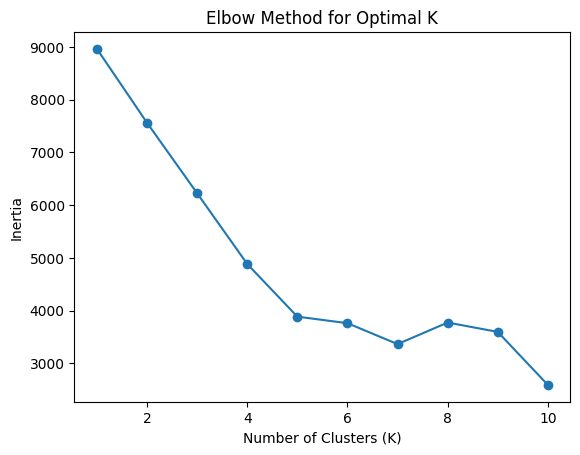

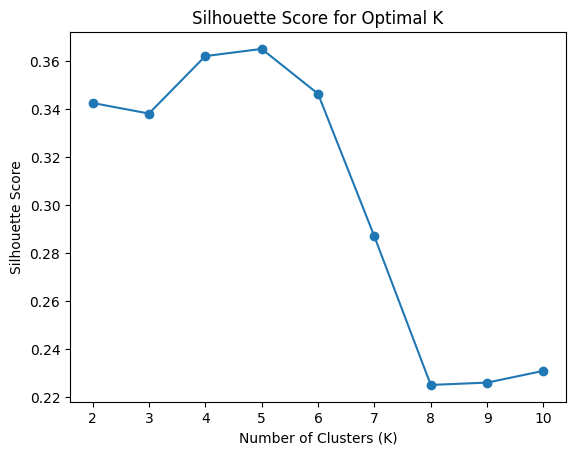

In [ ]:
inertia = []
silhouette_scores = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)
    if k > 1:
        silhouette_scores.append(silhouette_score(features_scaled, kmeans.labels_))

# Plot Elbow Method
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

# Plot Silhouette Scores
plt.plot(K_range[1:], silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

We can see that 5 is the optimal number of clusters by silouette score and 5 is the optimal by inertia (Elbow Method)
But when we plot it we can see it's not optimal and that 4 clusters fits better

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
df_clean['Cluster'] = kmeans.fit_predict(features_scaled)

/tmp/ipykernel_620430/3262813087.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Cluster'] = kmeans.fit_predict(features_scaled)


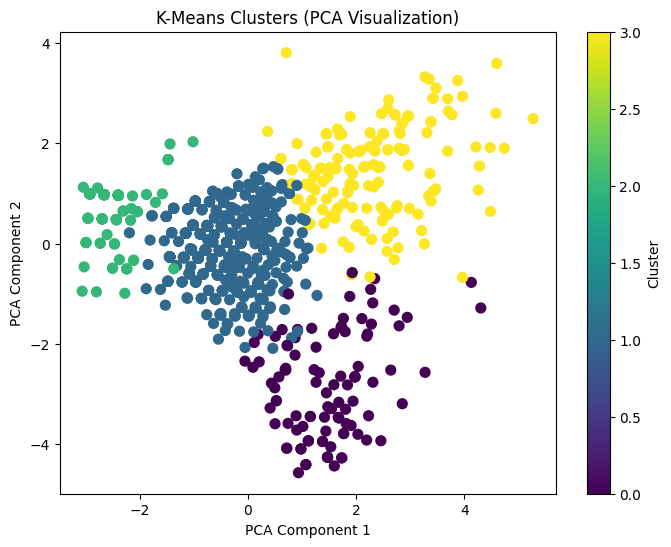

In [ ]:
# Perform PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)

# Plot the clusters in 2D space
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df_clean['Cluster'], cmap='viridis', s=50)
plt.title('K-Means Clusters (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
def anova(df):
    # Perform ANOVA test across clusters
    for col in df.columns[1:-1]:
        f_stat, p_value = f_oneway(df[df['Cluster'] == 0][col],
                                   df[df['Cluster'] == 1][col],
                                   df[df['Cluster'] == 2][col],
                                   df[df['Cluster'] == 3][col])
        print(f"ANOVA result for {col}: F-statistic = {f_stat}, p-value = {p_value}")

In [ ]:
anova(df_clean)

ANOVA result for Malignancy_value: F-statistic = 376.88208475663134, p-value = 2.5270828569730428e-163
ANOVA result for Calcification_value: F-statistic = 8670.456932383726, p-value = 0.0
ANOVA result for InternalStructure_value: F-statistic = 2.844300278035217, p-value = 0.03672168936943527
ANOVA result for Lobulation_value: F-statistic = 243.75278104693837, p-value = 1.7987540740716923e-118
ANOVA result for Margin_value: F-statistic = 275.1324114983043, p-value = 6.4910083336691745e-130
ANOVA result for Sphericity_value: F-statistic = 25.63755865239705, p-value = 5.610816851606739e-16
ANOVA result for Spiculation_value: F-statistic = 333.99794693013007, p-value = 7.21614000543504e-150
ANOVA result for Subtlety_value: F-statistic = 114.1463125612142, p-value = 1.690665803130858e-63
ANOVA result for Texture_value: F-statistic = 2459.0082719502107, p-value = 0.0


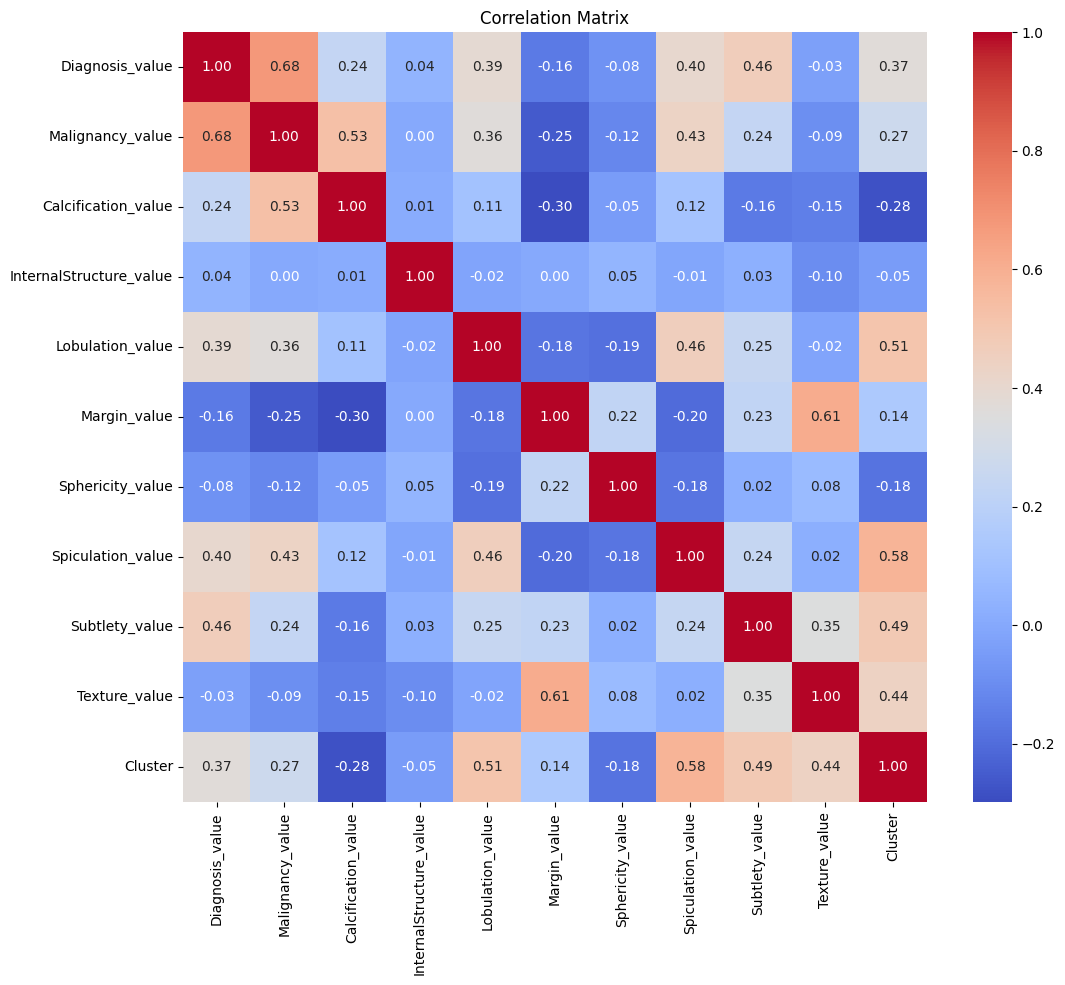

In [ ]:
correlation_matrix = df_clean.corr(method='pearson')
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

## Hierarchical Clustering

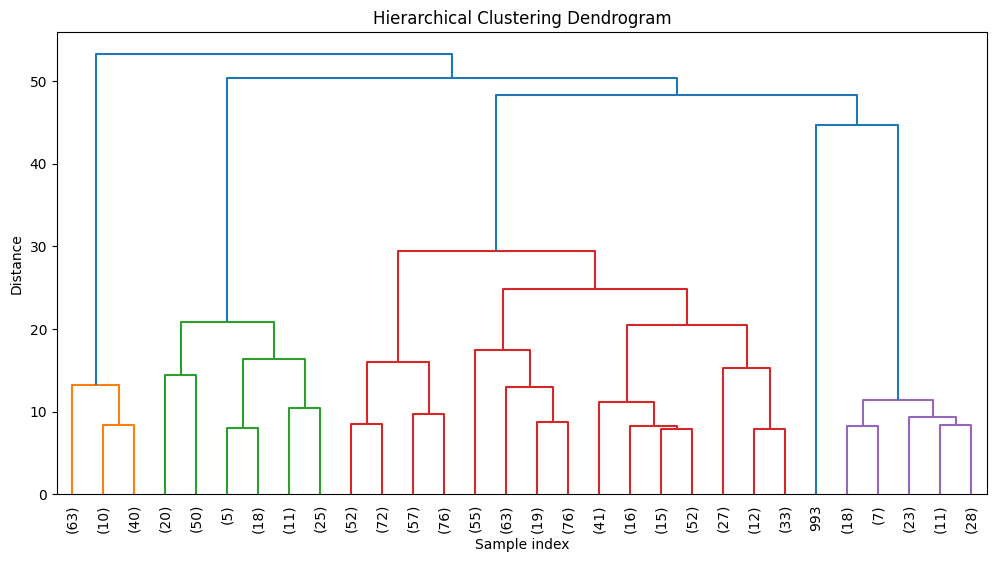

Cluster
3    666
2    129
1    113
4     88
Name: count, dtype: int64


/tmp/ipykernel_620430/4089490871.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hc['Cluster'] = cluster_labels


In [ ]:
df_hc = df[col_list]
# Perform linkage
Z = linkage(features_scaled, method='ward')  # You can also try 'average', 'complete', etc.

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=10.)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

# Assign cluster labels (e.g., 4 clusters)
cluster_labels = fcluster(Z, t=4, criterion='maxclust')
df_hc['Cluster'] = cluster_labels

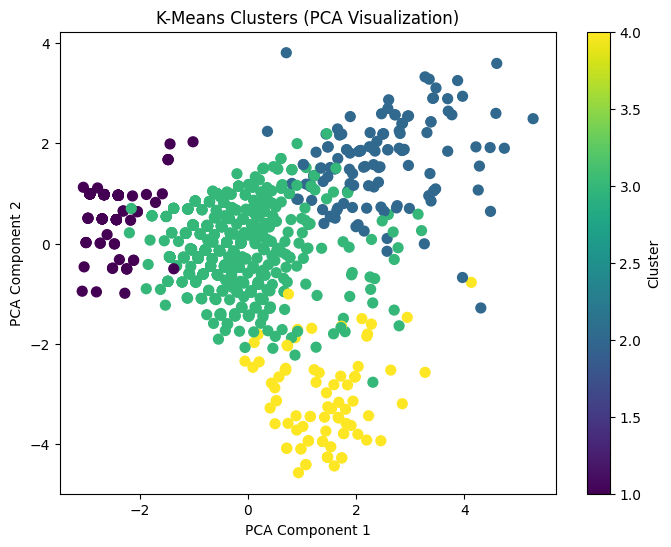

In [ ]:
# Perform PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)

# Plot the clusters in 2D space
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df_hc['Cluster'], cmap='viridis', s=50)
plt.title('K-Means Clusters (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
def anova(df):
    # Perform ANOVA test across clusters
    for col in df.columns[1:-1]:
        f_stat, p_value = f_oneway(df[df['Cluster'] == 1][col],
                                   df[df['Cluster'] == 2][col],
                                   df[df['Cluster'] == 3][col],
                                   df[df['Cluster'] == 4][col])
        print(f"ANOVA result for {col}: F-statistic = {f_stat}, p-value = {p_value}")
anova(df_hc)

ANOVA result for Malignancy_value: F-statistic = 296.6104204163635, p-value = 2.0708396686349521e-137
ANOVA result for Calcification_value: F-statistic = 9524.234898126566, p-value = 0.0
ANOVA result for InternalStructure_value: F-statistic = 3.4649556078721013, p-value = 0.015842889154605903
ANOVA result for Lobulation_value: F-statistic = 198.09536268139536, p-value = 1.1711601163318573e-100
ANOVA result for Margin_value: F-statistic = 207.01470785497227, p-value = 2.9594367054889734e-104
ANOVA result for Sphericity_value: F-statistic = 13.559284042739204, p-value = 1.126487563569639e-08
ANOVA result for Spiculation_value: F-statistic = 445.3564022718935, p-value = 3.3120301515405006e-183
ANOVA result for Subtlety_value: F-statistic = 111.3532290993103, p-value = 3.810233640056982e-62
ANOVA result for Texture_value: F-statistic = 1292.6086402924423, p-value = 0.0


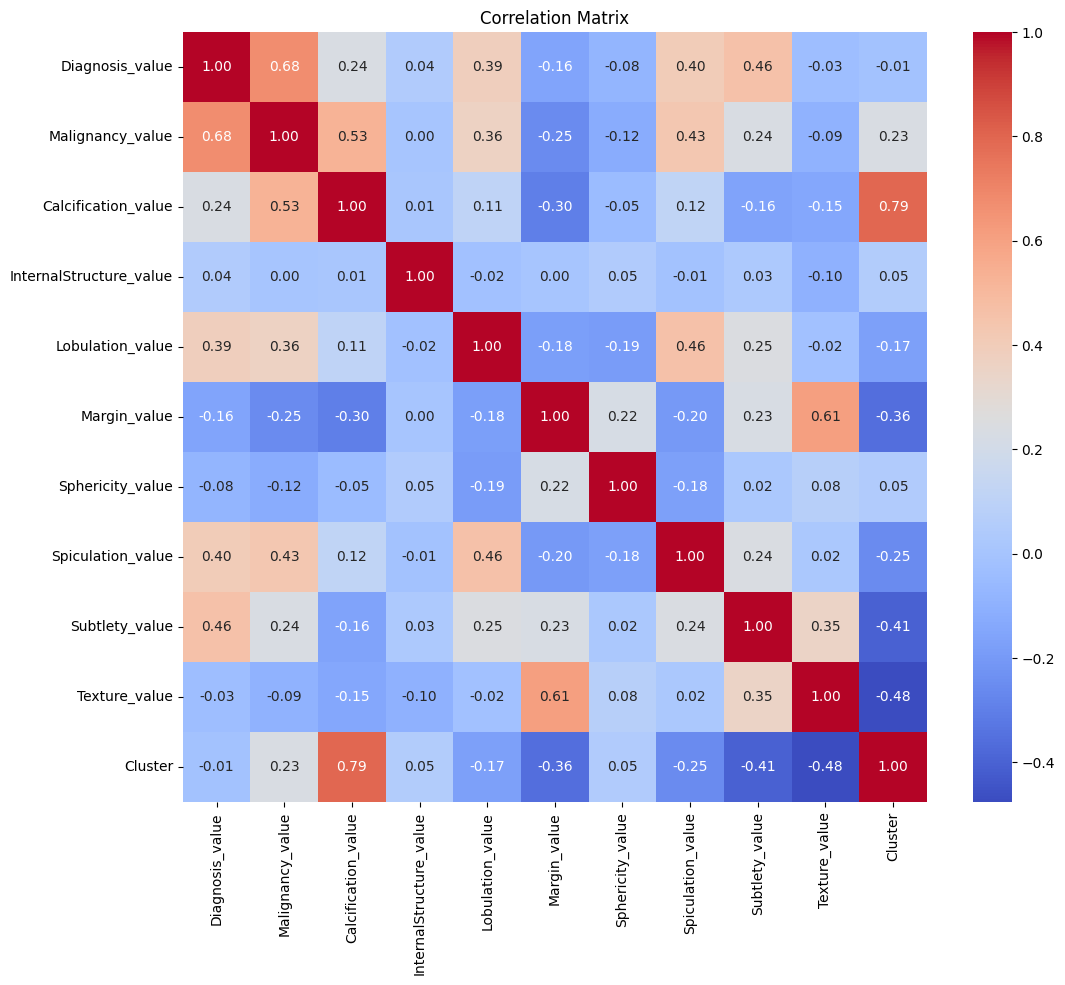

In [ ]:
correlation_matrix = df_hc.corr(method='pearson')
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()